# Competition 2: physical activity categorisation
In this notebook, we extracted features from continuous time series phone signals to predict the type of physical activity that generated a particular segment of recording. We used linear models such as multinomial logistic regression, linear discriminant analysis, naive bayes, and knn. We then compared model performance using cross-validation techniques.

In [3]:
library(tidyverse) 
list.files(path = "../input")

.... = NA

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()



[1] "bda2022signals"

In [4]:
# Make sure the data is available
if (length(list.files("../input", pattern = "recognition")) > 0) {
    
    # Copy all files to the current directory
    system("cp -r ../input/bda2022signals/* ./")
    
} else {
    
    # Download data for this competition
    data_url = "https://phonesensordata.netlify.app/Archive.zip"
    download.file(data_url, "Archive.zip")

    # Unzip all files in the current directory
    unzip("Archive.zip")
    
}

# list files in the current working directory
list.files()

# show the content of the labels file 
file.show("activity_labels.txt")

[1] "__MACOSX"                  "__notebook_source__.ipynb"
[3] "activity_labels.txt"       "Archive.zip"              
[5] "RawData"                   "README Raw.txt"

R Information

1 WALKING           
2 WALKING_UPSTAIRS  
3 WALKING_DOWNSTAIRS
4 SITTING           
5 STANDING          
6 LAYING            
7 STAND_TO_SIT      
8 SIT_TO_STAND      
9 SIT_TO_LIE        
10 LIE_TO_SIT        
11 STAND_TO_LIE      
12 LIE_TO_STAND      

The data files themselves are stored in the 'RawData' folder. This folder contains a folder 'Train' and a folder 'Test'. Let's look at the list of filenames in the 'Train' folder:

In [5]:
# Train and Test folder are located in the RawData folder
list.files("./RawData")

# The Train folder contains 85 files:
length(list.files("./RawData/Train"))

# A sample of the file names in the Train folder; notice the filename pattern
set.seed(1)
sample(list.files("./RawData/Train"),6)

[1] "Test"  "Train"

[1] 85

[1] "gyro_exp43_user21.txt" "acc_exp58_user29.txt"  "acc_exp01_user01.txt" 
[4] "acc_exp53_user26.txt"  "gyro_exp01_user01.txt" "acc_exp23_user11.txt"


# 1. Reading the data


The data are stored in text (.txt) files. 

- There are text files that store the signals for each user for each experiment (trial; 3 trials per person).
- There is a text file that stores the activity labels for segments of signals for all participants for each experiment.

The code below does most of the heavy lifting for you.

# 1.1 Import Activity labels

First import the activity labels:

In [6]:
act_labels = read_delim("activity_labels.txt"," ",col_names=FALSE,trim_ws=TRUE) 
act_labels = act_labels %>% select(X1,X2)
act_labels 

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 12 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: " "
chr  (1): X2
dbl  (1): X1
lgl (11): X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2
<dbl>,<chr>
1,WALKING
2,WALKING_UPSTAIRS
3,WALKING_DOWNSTAIRS
4,SITTING
5,STANDING
6,LAYING
7,STAND_TO_SIT
8,SIT_TO_STAND
9,SIT_TO_LIE


The signals themselves are stored in text files. In these files there are three columns; each column is the signal measured in one of the 3 channels of the sensor (these channels are associated in X, Y and Z direction). Each signal consists of a sequence of measurements, called _samples_.

For each subject the file `labels.txt` stores the trial number, user ID, activity together with the sample number at which the activity started, and the sample number at which time the activity ended.

In [7]:
labels = read_delim("./RawData/Train/labels_train.txt", " ", col_names = F)
colnames(labels) <- c('trial', 'userid', 'activity', 'start', 'end')

labels = labels %>% mutate(activity = act_labels$X2[activity])

Rows: 849 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: " "
dbl (5): X1, X2, X3, X4, X5

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Let's have a look at the labels data frame:

In [8]:
print(labels)

# A tibble: 849 × 5
   trial userid activity     start   end
   <dbl>  <dbl> <chr>        <dbl> <dbl>
 1     1      1 STANDING       250  1232
 2     1      1 STAND_TO_SIT  1233  1392
 3     1      1 SITTING       1393  2194
 4     1      1 SIT_TO_STAND  2195  2359
 5     1      1 STANDING      2360  3374
 6     1      1 STAND_TO_LIE  3375  3662
 7     1      1 LAYING        3663  4538
 8     1      1 LIE_TO_SIT    4539  4735
 9     1      1 SITTING       4736  5667
10     1      1 SIT_TO_LIE    5668  5859
# … with 839 more rows
# ℹ Use `print(n = ...)` to see more rows


The data frame encodes the `start` and `end` sample for each subsequent activity in signal files, for each `trial` and `userid`.  

What should be noticed is that some activities were repeated at different times during the recording, which results in multiple time (sample) windows in which the participant was for instance `WALKING_UPSTAIRS`.

For each user there are several files. Although you may be inclined to think in terms of "users" (as they are participants), it's easier to focus on the files, because there are in some cases multiple files per user.

Here we'll import only the files of which the filename starts with 'acc' (for 'accelorometer' as opposed to 'gyroscope'). 

The filenames contain information about the participant ID (prefixed with `user`), and about the experimental trial (prefixed with `exp`). The latter isn't very usefull, but we will need it anyway extract the proper rows from the `labels` data frame above. We need to retain this information, and therefore we use "regular expressions" to extract them.

# 1.2 Import the signals

Let's import the signals. We'll first look at participant with `userid` = 1, `trial` = 1 and see how we can import the signals, and then label each sample in the signal with the activity labels stored in the `labels` data frame. Once we have figured out how to do this for one individual we can use this as a template for doing others and write a function to do this for us.


In [9]:
# identify the file name and extract the 'username' (participant ID) and 'expname' (experimental trial)
filename = "RawData/Train/acc_exp01_user01.txt"
username = gsub(".+user(\\d+).+", "\\1", filename) %>% as.integer()
expname  = gsub(".+exp(\\d+).+", "\\1", filename) %>% as.integer()

# import the data from the file
user01 = read_delim(filename, " ", col_names = F)

Rows: 20598 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: " "
dbl (3): X1, X2, X3

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Let's have a peek at the imported data to make sure nothing went wrong:

In [10]:
head(user01)

X1,X2,X3
<dbl>,<dbl>,<dbl>
0.9180556,-0.11250000,0.5097223
0.9111111,-0.09305556,0.5375000
0.8819445,-0.08611111,0.5138889
0.8819445,-0.08611111,0.5138889
0.8791667,-0.10000000,0.5055556
0.8888890,-0.10555556,0.5125000


Each column is a signal. Subsequent rows are subsequent measurement samples, and so we treat rownumber as a time indicator (to keep the distinction clear we'll talk about sample number).

To further check that we read the singals in without errors, and to gain some understanding of the data structure, let's have a look at the signal wave forms:

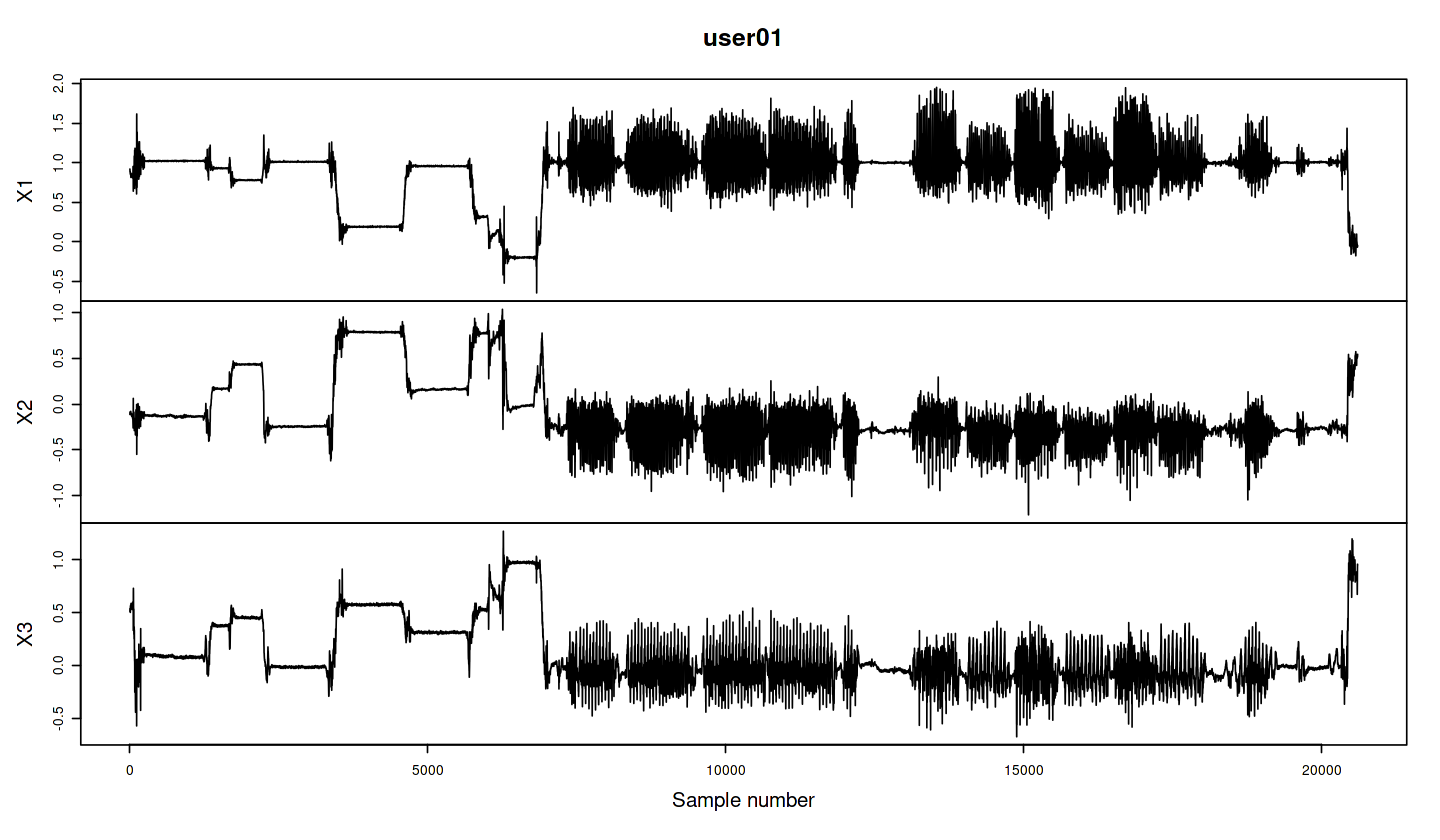

In [11]:
options(repr.plot.width=12)

plot.ts(user01, xlab="Sample number")

We see clearly different segments from horizontal axis correspond to different activities. There is some regularity to the signals. The data seem to have been read in correctly. If different segments of the signals belong to different physical activities, we will need to label each of the samples with the correct activity.


# 1.3 Merging Signals and Labels

The data frame `labels` contains this information, but in a somewhat odd format: Each row specifies at which samples an activity for a given participant in a given experimental run started and ended. For example, the first two rows


In [12]:
print(labels[1:2,])

# A tibble: 2 × 5
  trial userid activity     start   end
  <dbl>  <dbl> <chr>        <dbl> <dbl>
1     1      1 STANDING       250  1232
2     1      1 STAND_TO_SIT  1233  1392


It is much handier to have a data frame that gives an activity label for each `trial`, `userid` and each time `sampleid` that has matching rows for each row in the signals data frame. 

We can compute this from the `labels` data frame with a nifty feature that you may not know about: Cells in a `tibble` can contain a `list()`. This is usefull for storing groups of values that all share the same values on other variables. Tibbles with such cells are called "nested". They can be expanded to a normal `tibble` or data frame with the `dplyr::unnest()` function. We'll use above `label` data frame to demonstrate this: First we add the sequence `start:end` inside a `list()` to each row of `labels`. For instance, the first two rows above become 

```
  trial userid activity     start   end sampleid 
  <dbl>  <dbl> <chr>        <dbl> <dbl> <list>   
1     1      1 STANDING       250  1232 list( 250:1232)
2     1      1 STAND_TO_SIT  1233  1392 list(1233:1392)
```

In [13]:
# Add the sequence start:end to each row in a list.
# The result is a nested table:
sample_labels_nested = 
    labels %>% 
    rowwise() %>% # do next operation(s) rowwise
    mutate(sampleid = list(start:end)) %>%
    ungroup()

# Check the resulting table:
print(sample_labels_nested, n=6) 

# A tibble: 849 × 6
  trial userid activity     start   end sampleid     
  <dbl>  <dbl> <chr>        <dbl> <dbl> <list>       
1     1      1 STANDING       250  1232 <int [983]>  
2     1      1 STAND_TO_SIT  1233  1392 <int [160]>  
3     1      1 SITTING       1393  2194 <int [802]>  
4     1      1 SIT_TO_STAND  2195  2359 <int [165]>  
5     1      1 STANDING      2360  3374 <int [1,015]>
6     1      1 STAND_TO_LIE  3375  3662 <int [288]>  
# … with 843 more rows
# ℹ Use `print(n = ...)` to see more rows


Note that dplyr prints only a summary of the 'sampleid' column, in a rather abstract way (e.g., `<int [983]>` under `sampleid` means: `sampleid` contains 983 integers for row 1).


Next we unnest the nested tibble `sample_labels_nested` to obtain a table that for each `sampleid` value stores the right `activity` label. There is however one issue: Each row corresponds to a signal segment of an activity. Some of the activities, such as WALKING, were done multiple times in the same experiment in different time segments. We need to be able to identify different segments of WALKING. Therefore, before unnesting, we'll add the row numbers as `segment` ID:


In [14]:
# Unnest the nested tabel.
sample_labels = 
    sample_labels_nested %>% 

    # Rows are segments, we need to keep track of different segements
    mutate(segment = row_number() ) %>% 

    # Expand the data frame to one sample per row
    unnest(cols = c(sampleid)) %>% 

    # Remove columns we don't need anymore
    select(-start, -end) 


# Check the result (first few rows are not interesting; rows 977-990 are)
print(sample_labels[977:990, ])

# A tibble: 14 × 5
   trial userid activity     sampleid segment
   <dbl>  <dbl> <chr>           <int>   <int>
 1     1      1 STANDING         1226       1
 2     1      1 STANDING         1227       1
 3     1      1 STANDING         1228       1
 4     1      1 STANDING         1229       1
 5     1      1 STANDING         1230       1
 6     1      1 STANDING         1231       1
 7     1      1 STANDING         1232       1
 8     1      1 STAND_TO_SIT     1233       2
 9     1      1 STAND_TO_SIT     1234       2
10     1      1 STAND_TO_SIT     1235       2
11     1      1 STAND_TO_SIT     1236       2
12     1      1 STAND_TO_SIT     1237       2
13     1      1 STAND_TO_SIT     1238       2
14     1      1 STAND_TO_SIT     1239       2


Now that we have each sample labeled with an activity, we can add the corresponding signals values that are stored in `user01`.

Let's put the signals `user01` in a data frame in which we include the `userid`, the `trial` number, and a `sampleid` for each row in `user01`. Then we'll use a `left_joint()` to merge the activity labels: 

In [15]:
user_df = 
    # Store signals user01 in a data frame, with 'userid' and 'trial'
    data.frame(userid = username, trial = expname, user01) %>%

    # Add 'sampleid' for matching the sampleid's in 'sample_labels'. 
    # The first sample in user01 signals always has sampleid=0; the last
    # has sampleid is therefore nrow(user01)-1.
    mutate(sampleid = 0:(nrow(user01)-1) ) %>%

    # Add the labels stored in sample_labels
    left_join(sample_labels) 

# Check the result (first few rows are not interesting; the following are)
print(user_df[1227:1239, ])

Joining, by = c("userid", "trial", "sampleid")


     userid trial       X1         X2         X3 sampleid     activity segment
1227      1     1 1.022222 -0.1375000 0.07500000     1226     STANDING       1
1228      1     1 1.019445 -0.1347222 0.07361111     1227     STANDING       1
1229      1     1 1.022222 -0.1375000 0.07777778     1228     STANDING       1
1230      1     1 1.025000 -0.1375000 0.07638889     1229     STANDING       1
1231      1     1 1.030556 -0.1444445 0.07916667     1230     STANDING       1
1232      1     1 1.016667 -0.1430556 0.05833334     1231     STANDING       1
1233      1     1 1.015278 -0.1416667 0.05972222     1232     STANDING       1
1234      1     1 1.020833 -0.1638889 0.05555556     1233 STAND_TO_SIT       2
1235      1     1 1.027778 -0.1736111 0.06944445     1234 STAND_TO_SIT       2
1236      1     1 1.025000 -0.1638889 0.05833334     1235 STAND_TO_SIT       2
1237      1     1 1.022222 -0.1472222 0.04861111     1236 STAND_TO_SIT       2
1238      1     1 1.022222 -0.1597222 0.04305556    

This table is exactly what we need: Each sample from signals in `X1`, `X2`, and `X3` now are labeled with an `activity`.


To check if the labeling is now correct, we'll visualize the result. We'll use `ggplot()` which allows to give different signal segments different colors to label the activity in that segment:

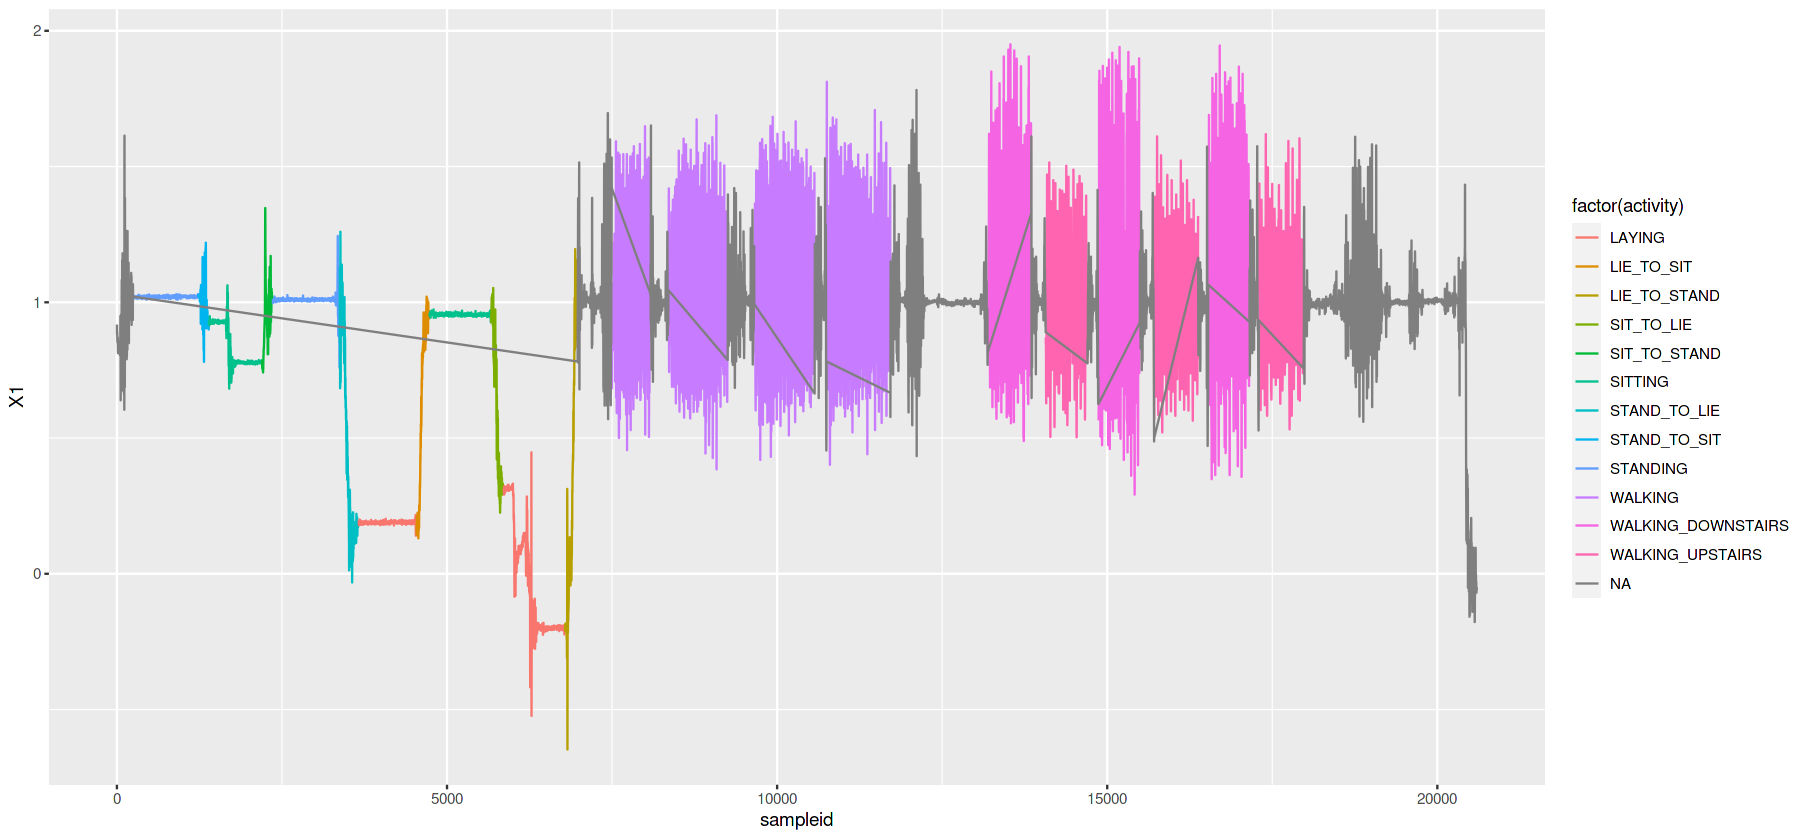

In [16]:
options(repr.plot.width=15) # change plot width for nicer output

user_df %>% 
  ggplot(aes(x = sampleid, y = X1, col = factor(activity), group=segment)) + 
      geom_line()  

*Note: In the plot you'll notice the weird gray lines crossing through the plot. The gray trace corresponds to non-labeled segments (labeled `NA` in the legend of the plot). The segments that are labeled with an activity are interspersed with short unlabeled segments, which are drawn in gray, which causes the gray trace to connect different unlabeled segments.*

Notice that some samples have been labeled `NA`, meaning _any activity that is not on the list_. Whole sections of signal consist of this unlisted activity.


# 2. Feature Extraction

Having all the data in one tidy table, we are now ready to extract features that can be used by the various classification algorithms.


# 2.1 Time domain features

For the classification algorithms discussed in chapter 4 of ISLR, the time samples themselves are not useful features. To see this, consider the following plot which shows segments with typical walking cycles (hand picked by closely inspecting the signals).


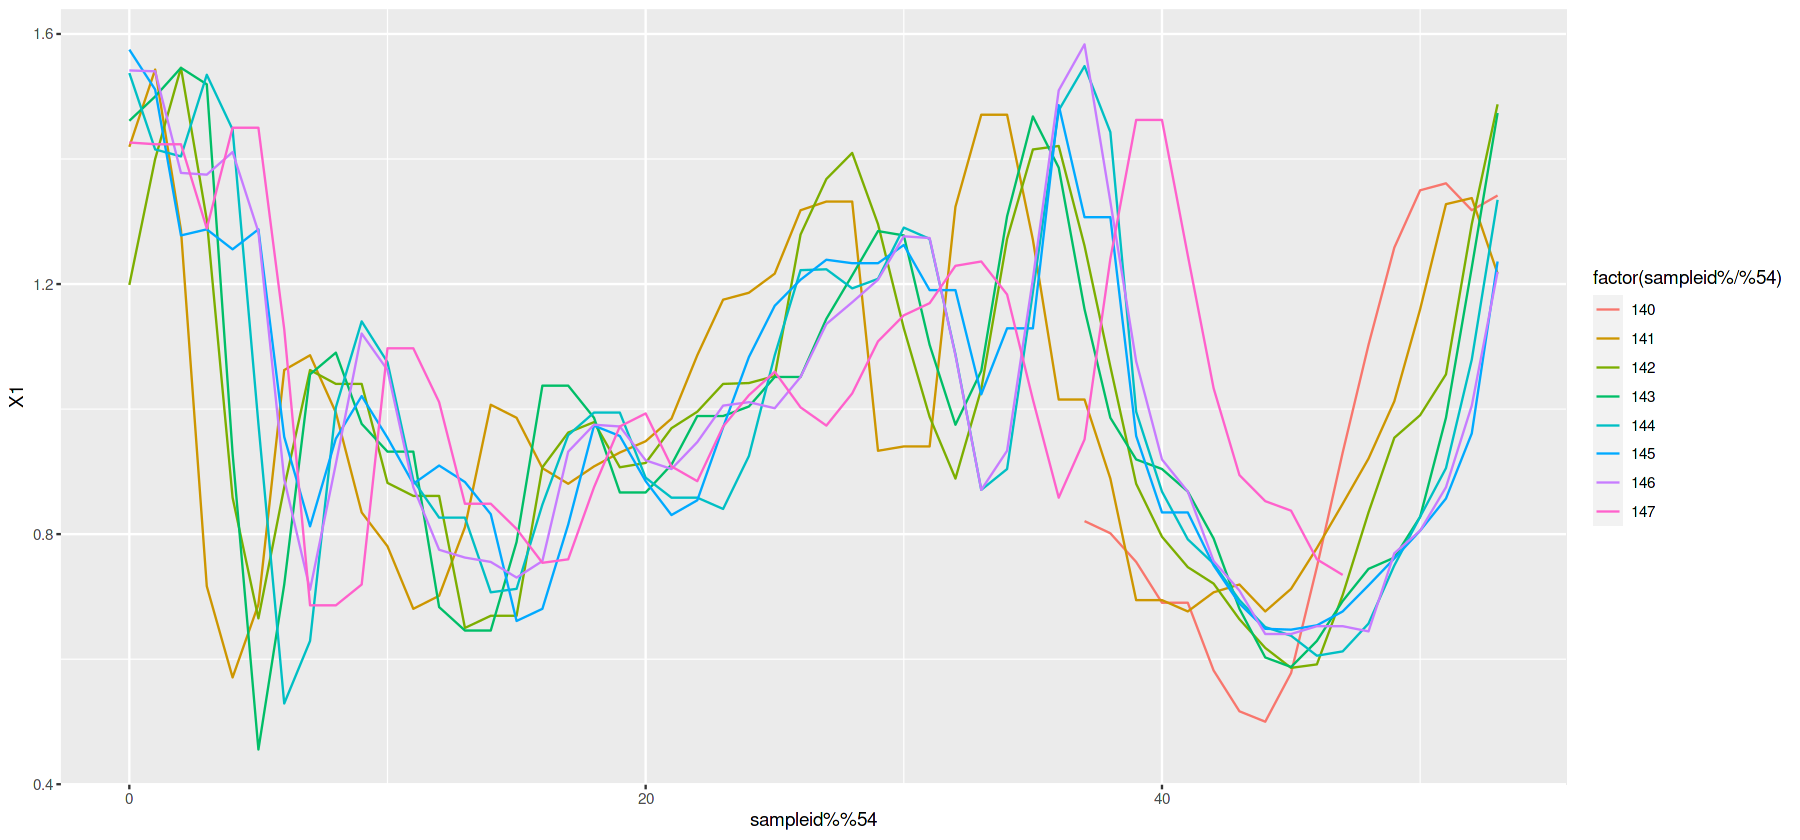

In [17]:
user_df %>% 

  # change 7986 to 8586 to see shifted walk cycle
  dplyr::filter(activity == "WALKING", segment == 13, 
    7596 < sampleid & sampleid < 7986) %>% 

  ggplot(aes(x = sampleid %% 54, y = X1, group = sampleid %/% 54, 
             col = factor(sampleid %/% 54))) + geom_line() 

Here we defined a time window of 54 samples, in which one complete walking cycle is finished; the next walking cycles are plotted on top of each other. The pattern is clear. The problem is 

1. that we don't know how long the typical pattern is (i.e., how many samples it spans), and 
2. that the pattern may be shifted relative to the start of our time window so that it appears _shifted_ 

Shifting can occur for any reason, and is visible if you change the `filter` argument `sample < 7986` to `sample < 8686` to show more steps from the signal: the extra steps seem to have shifted.

If we try to combine signals from multiple participants we wouldn't even know how to align the samples. So, it's unclear how you should decide which samples from different participants are observations for the same 'feature'.

Hence, the samples themselves are better not used as features. What we have to do is compute features that are (more or less) invariant to time shifts. One way to do this is by simply ignoring the time order of the values and look at them as a collection of numbers. The best way to look at unordered collections of numbers is to look at statistical summaries.

For instance, have a look at the histograms of the signal samples per activity:

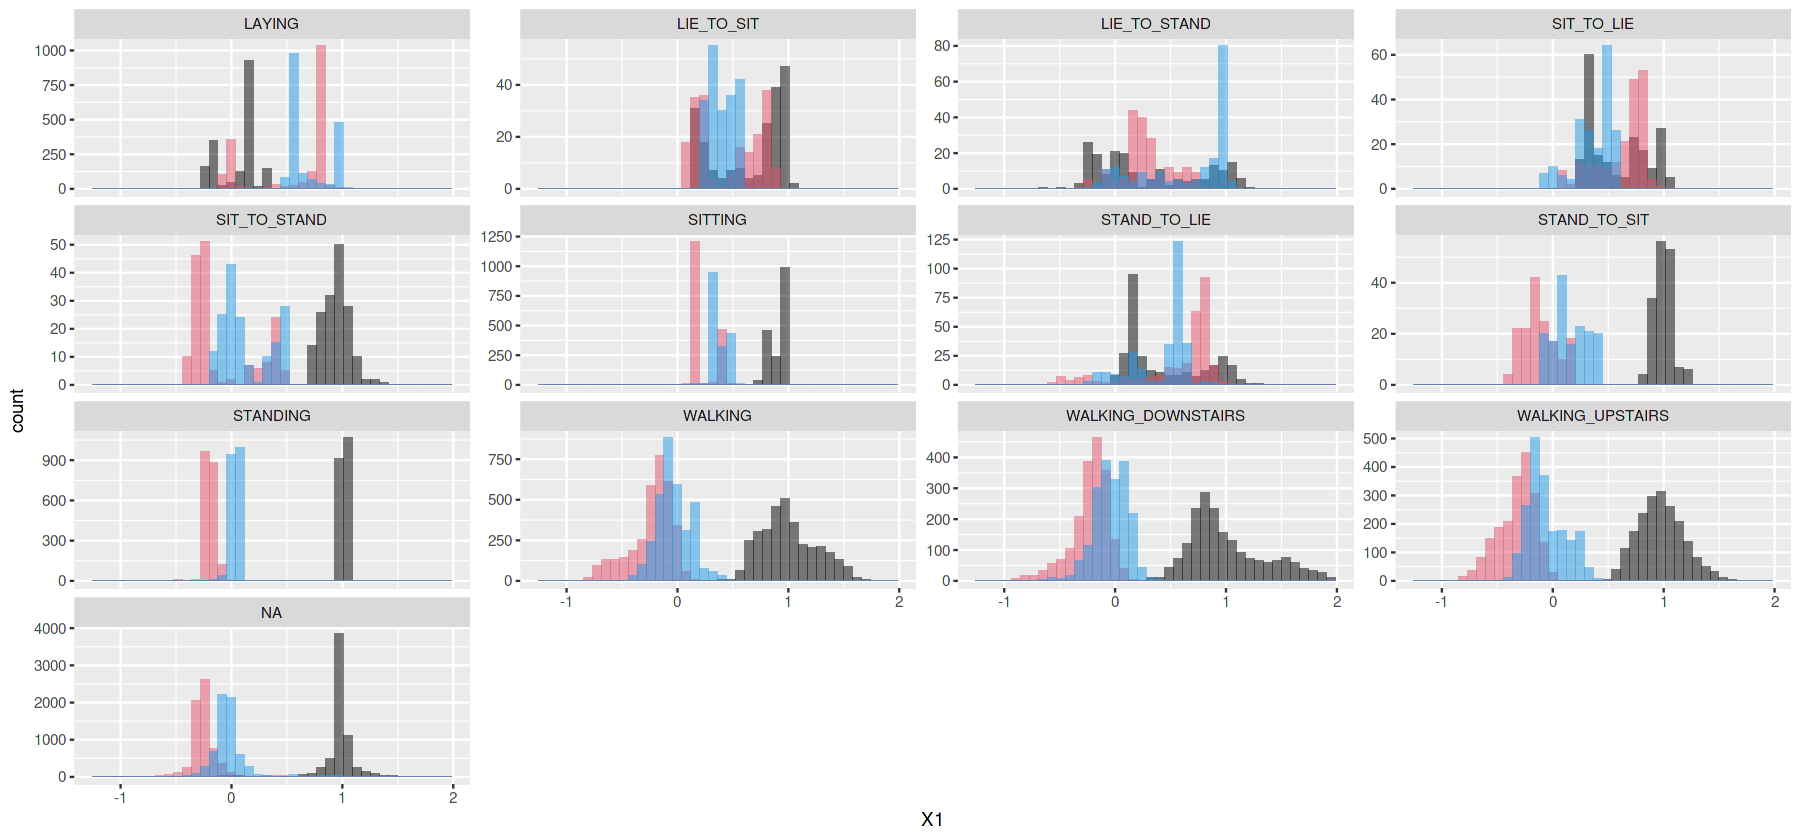

In [18]:
user_df %>%
    ggplot(aes(X1)) + 
      geom_histogram(bins=40, fill=1, alpha=0.5) + 
      geom_histogram(aes(X2), bins=40, fill = 2, alpha=0.5) + 
      geom_histogram(aes(X3), bins=40, fill = 4, alpha=0.5) +
      facet_wrap(~activity, scales = "free_y")

The histograms are quite distinct, and we can exploit these differences to recognize the activity. 

Histograms give a detailed picture of the distribution of the numbers that make up the signal; perhaps a little too detailed. In stead we can also look a less detailed characterization of the distribution, such as their location of the distribution (i.e., the _mean_), and the width of the distribtuion (_standard deviation_). 

In fact, we can compute all kinds of statistics from the signal samples that characterize the shapes of these histograms. For instance, we can compute the means of the signal samples, the standard deviation, skewness, inter-quartile ranges, etc. These simple statistical summary measures often yield good predictive features.

# Epochs

Now there's one other thing concerning these signals: The signals have different activities at different times, and in general, we don't know when an activity is going to start or end. 

In the Test data set you will be asked to predict the activities in subsequent time windows, called _epochs_, of 128 samples (=128 / 50Hz = 2.56 sec). So you will also have to train a prediction algorithm on the signals that are segmented into _epochs_ of 128 samples.

To do so, we use a clever trick involving integer division: By dividing the sample number by 128 we obtain an integer that will group samples into epochs. For instance say we have sample numbers 0, 2, 3, ..., 14, and we want to group them into 4 epochs of length 3, then integer division yields:

In [19]:
0:14 %/% 3

[1] 0 0 0 1 1 1 2 2 2 3 3 3 4 4 4

We use this trick to group the rows in `user` into epochs, and then compute summary statistics per epoch. The result is a data frame with as many rows as there are epochs, and on each row the summary statistics computed. 

As an example of this, look at the following

In [20]:
user_df %>%
  # add an epoch ID variable (on epoch = 2.56 sec)
  mutate(epoch = sampleid %/% 128) %>% 
  # group by 'epoch'
  group_by(epoch) %>%
  # compute mean features and standard deviation features
  summarise(mean_X1 = mean(X1), mean_X2 = mean(X2), mean_X3 = mean(X3)) %>%
  # inspect the first 6 epochs
  head()

epoch,mean_X1,mean_X2,mean_X3
<dbl>,<dbl>,<dbl>,<dbl>
0,0.908941,-0.1649089,0.25218100
1,1.015723,-0.1324110,0.05088976
2,1.019217,-0.1241102,0.09873047
3,1.020074,-0.1254232,0.09264323
4,1.020172,-0.1297960,0.08509115
5,1.020757,-0.1285590,0.08496094


What we did here was the following

1. We divided up the samples into 'epochs' (and computed an 'epoch' id),
2. we then grouped the resulting data frame by 'epoch' id,
3. and then we computed the mean of the signal samples in each epoch, for each of the 3 signals

This is the pattern that you're going to use to compute all kinds of features that are defined in terms of statistics.

You'll want to define more creative features for which there is not a simple function such as `mean` or `sd` predefined in R. You'll have to write functions for such features yourself. (_This also makes it easy to divided the feature coding between all team members!_)

The following code defines some such functions, and then employs steps 1 through 3 above to calculate those features:

# 2.1 Time domain features

In [21]:
# AUTOCORRELATION

lagged_cor = function(x, y=x, lag=0) {
    # compute correlation between x and a time shifted y
    r_lagged = cor(x, dplyr::lag(y, lag), use='pairwise')
    return(r_lagged)
}

# 2.2 Frequency domain features



In [22]:
# FREQENCY, POWER, AND ENTROPY PER FREQUENCY BAND
# MEAN FREQUENCY AND STANDARD DEVIATION

band_peak_freq_pow = function(x, axis, band_len=8) {
    # spectrum density 
    spec = spectrum(x, plot=FALSE)
    bands = seq(0, max(spec$freq), len=band_len) # divide all frequencies into bands 
    
    df_freq = spec$freq[2] - spec$freq[1]
    sbar = sum(spec$freq * spec$spec * df_freq) 
    svar = sum((spec$freq - sbar)^2 * spec$spec * df_freq) 
    
    df <- spec %>%
      broom::tidy() %>%
      mutate(band = findInterval(freq, bands)) %>% # find band to which freq belongs
      group_by(band) %>%
      summarise(
          band_peak_freq = freq[which.max(spec)], 
          band_power = mean(spec), 
          band_entro = sum(-log(spec)*spec)
      )
    
    # rename colname so results can be joined later 
    colnames(df)[2:4]=c(
        paste(c(axis, 'band_peak_freq'), collapse="_"),
        paste(c(axis, 'band_power'), collapse="_"), 
        paste(c(axis, 'band_entro'), collapse="_")
    )
    
    w = ncol(df)
    df = df %>%
        pivot_wider(names_from='band', values_from=colnames(df)[2:w])
    
    mean_name <- paste(c(axis, 'mean_freq'), collapse="_")
    df[,mean_name] <- sbar
    
    sd_name <- paste(c(axis, 'sd_freq'), collapse="_")
    df[,sd_name] <- svar
    
    return(tibble(df))
}

# 2.3 Histogram based features

In [23]:
#FUNCTION TO MAKE A HISTOGRAM
get_histogram = function(variable) {
    h = hist(variable, breaks = 40, plot = FALSE)       
  return(h)  
} 

#FUNCTION FOR MODE
get_mode = function(variable) {
    hist = get_histogram(variable)
    mode = hist$mids[which.max(hist$counts)]
    return(mode)
}

#MEDIAN
get_median = function(variable) {
    hist = get_histogram(variable)
    median = hist$mids[round(length(hist$mids)*0.5)]
    return(median)
}

#DIFFERENCE MINIMUM MAXIMUM VALUE/RANGE
get_range = function(variable) {
    hist = get_histogram(variable)
    range = max(hist$breaks) - min(hist$breaks)
    return(range)
}


#TOTAL COUNT OF BINNED VALUES
get_count = function(variable) {
    hist = get_histogram(variable)
    count = sum(!hist$counts == 0)
    return(count)
}


#DIFFERENCE MEAN AND MAXIMUM
get_mm_diff = function(variable) {
    hist = get_histogram(variable)
    dx = hist$mids[2] - hist$mids[1]
    m = sum(hist$mids * hist$density * dx)
    mm_diff = max(hist$breaks) - m
    return(mm_diff)
}


#MODE PERCENTILE
get_perc = function(variable) {
    hist = get_histogram(variable)
    p = which.max(hist$counts)/length(hist$counts)
    return(p)
}


#RATIO OF MODE COUNTS TO ALL OTHERS COUNTS
get_ratio = function(variable) {
    hist = get_histogram(variable)
    ratio = max(hist$counts)/sum(hist$counts[!hist$counts == max(hist$counts)])
    return(ratio)
}

# 2.4 Distribution based features

In [24]:
# NORMALITY OF THE VALUES

normality = function(x) {
    
    # shapiro.test expects vectors of lenght at least 3 
    if (length(x) < 3){
        return(0)
    } else {
        # Using the shapiro wilk normality test and using its W statistic for normality
        # The W statistic will take a value between 0 and 1 with 1 being a perfect match
        test <- shapiro.test(x)[1]
        W <- unlist(test)
        
        return(W)
    }
}

f_test = function(x1, x2, x3){
    
    # Within variable variance/between variable variance per axis
    # So basically computing an f test
    df <- data.frame(x1,x2,x3)
    
    # Between variance
    n <- length(x1)
    means <- c(mean(x1), mean(x2), mean(x3))
    overall_mean <- mean(means)
    between_var <- n*(sum((means-overall_mean)^2))
    
    # Within variance
    within_var <- sum(apply(sweep(df, 2, means), 2, sum)^2)
    
    f <- between_var/within_var   
    f <- log(f+1) # The f values are very large so we take the log
    
    return(f)
}

# 2.5 Linear trend

In [25]:
# compute the linear trend of each epoch
linear_trend = function(x) {
    t = c(1:length(x))
    lm = lm(x~t)
    return(lm$coefficients['t'])
}

# 2.6 Helper functions

In [26]:
most_common_value = function(x) {
    counts = table(x, useNA='no')
    most_frequent = which.max(counts)
    return(names(most_frequent))
}

# 3. Putting it all together

We've just processed only one file. We need to process all of them and combine the resulting data frames in one big data frame. Here is code for doing that for the accelerometer data files (the ones starting with `acc`). You will need to do the same for the gyroscope data (filenames starting with `gyro`).

To obtain a list of all the files, use `dir()`:


In [27]:
list.files("./RawData/Train/", pattern = "^acc")

[1] "acc_exp01_user01.txt" "acc_exp02_user01.txt" "acc_exp05_user03.txt"
 [4] "acc_exp06_user03.txt" "acc_exp09_user05.txt" "acc_exp10_user05.txt"
 [7] "acc_exp11_user06.txt" "acc_exp12_user06.txt" "acc_exp13_user07.txt"
[10] "acc_exp14_user07.txt" "acc_exp15_user08.txt" "acc_exp16_user08.txt"
[13] "acc_exp22_user11.txt" "acc_exp23_user11.txt" "acc_exp28_user14.txt"
[16] "acc_exp29_user14.txt" "acc_exp30_user15.txt" "acc_exp31_user15.txt"
[19] "acc_exp32_user16.txt" "acc_exp33_user16.txt" "acc_exp34_user17.txt"
[22] "acc_exp35_user17.txt" "acc_exp38_user19.txt" "acc_exp39_user19.txt"
[25] "acc_exp42_user21.txt" "acc_exp43_user21.txt" "acc_exp44_user22.txt"
[28] "acc_exp45_user22.txt" "acc_exp46_user23.txt" "acc_exp47_user23.txt"
[31] "acc_exp50_user25.txt" "acc_exp51_user25.txt" "acc_exp52_user26.txt"
[34] "acc_exp53_user26.txt" "acc_exp54_user27.txt" "acc_exp55_user27.txt"
[37] "acc_exp56_user28.txt" "acc_exp57_user28.txt" "acc_exp58_user29.txt"
[40] "acc_exp59_user29.txt" "acc_exp60_user30.txt" "acc_exp61_user30.txt"

It's very handy, if not essential, to define a function that takes a data file name and carries out all the steps above. 

Here's such a function (its just copies the code above, and returns the result):

In [28]:
extractTimeDomainFeatures <- function(filename, sample_labels) {
    
    # extract user and experimental run ID's from file name
    username = gsub(".+user(\\d+).+", "\\1", filename) %>% as.numeric()
    expname  = gsub( ".+exp(\\d+).+", "\\1", filename) %>% as.numeric()
    
    # import the sensor signals from the file
    user01 <- read_delim(filename, " ", col_names = F, progress = TRUE, 
                 col_types = "ddd")
    
    
    # merge signals with labels 
    user_df <- 
        data.frame(userid = username, trial = expname, user01) %>%
        mutate(sampleid = 0:(nrow(user01)-1) ) %>%
        left_join(sample_labels, by = c('userid','trial','sampleid')) 

    
    # split in epochs of 128 samples and compute features per epoch
    usertimedom <-  user_df %>%
    
          # add an epoch ID variable (on epoch = 2.56 sec)
          mutate(epoch = sampleid %/% 128) %>% 

          # extract statistical features from each epoch
          group_by(epoch) %>%
          summarise(
            # keep track of user and experiment information
            user_id = username, 
            exp_id = expname,   
              
            # epoch's activity labels and start sample
            activity = most_common_value(c("-", activity)),
            sampleid = sampleid[1],
            
            ###############################
            # Histogram Features  
            ###############################
            # Mean features
            m1 = mean(X1), 
            m2 = mean(X2),
            m3 = mean(X3),
            
            # Standard deviation
            sd1 = sd(X1), 
            sd2 = sd(X2),
            sd3 = sd(X3),
              
            # Quantile 25
            q1_25 = quantile(X1, .25),
            q2_25 = quantile(X2, .25),
            q3_25 = quantile(X3, .25),
              
            # Quantikle 50
            q1_50 = quantile(X1, .50),
            q2_50 = quantile(X2, .50),
            q3_50 = quantile(X3, .50),
              
            # Quantile 75
            q1_75 = quantile(X1, .75),
            q2_75 = quantile(X2, .75),
            q3_75 = quantile(X3, .75),
              
              
            # Skew   
            skew1 = e1071::skewness(X1),
            skew2 = e1071::skewness(X2),
            skew3 = e1071::skewness(X3),
              
            # Kurstosis  
            kurt1 = e1071::kurtosis(X1),
            kurt2 = e1071::kurtosis(X2),
            kurt3 =  e1071::kurtosis(X3),
            
            # Mode
            mode1 = get_mode(X1),
            mode2 = get_mode(X2),
            mode3 = get_mode(X3),
            
              
            # Range
            range1 = get_range(X1),
            range2 = get_range(X2),
            range3 = get_range(X3),
             
            # Total count of bars(grouped values) in histogram
            count1 = get_count(X1), 
            count2 = get_count(X2),
            count3 = get_count(X3),
            
            # Difference between mean and maximum
            mm_diff1 = get_mm_diff(X1),
            mm_diff2 = get_mm_diff(X2),
            mm_diff3 = get_mm_diff(X3),    
            
            # Percentile of mode
            mode_perc1 = get_perc(X1),
            mode_perc2 = get_perc(X2),
            mode_perc3 = get_perc(X3),
        
            # Ratio of frequencies in mode compared to the rest
#             mode_ratio1 = get_ratio(X1),
#             mode_ratio2 = get_ratio(X2),
#             mode_ratio3 = get_ratio(X3),
              
            ###############################
            # time domain features
            ###############################
            # Autocorrelation
            AR1_1 = lagged_cor(X1, lag=1), 
            AR1_2 = lagged_cor(X1, lag=2),
            AR12_1 = lagged_cor(X1, X2, lag=1),
            
            ###############################
            # distribution features
            ###############################
            # Normality
            norm_1 = normality(X1),
            norm_2 = normality(X2),
            norm_3 = normality(X3),
            
            # F test
            f = f_test(X1, X2, X3),
              
            ###############################
            # linear trend 
            ###############################
            linear_trend1 = linear_trend(X1),
            linear_trend2 = linear_trend(X2),
            linear_trend3 = linear_trend(X3),
              
            ###############################
            # frequency domain features
            ###############################
    
            # band peak freqency, power, entropy, mean, sd
            band_peak_freq_pow(X1, 'X1'), 
            band_peak_freq_pow(X2, 'X2'), 
            band_peak_freq_pow(X3, 'X3'),
              
            
            n_samples = n()
          ) 
    
    # Some of the functions return NA's for some very short epochs. We replace them with the mean of the column.
    if (sum(is.na(usertimedom)) > 0){
        usertimedom <- usertimedom %>% 
            mutate_all(~ifelse(is.na(.x), mean(.x, na.rm = TRUE), .x))   
    }
    
    usertimedom 
}

This is not the most efficient way to organize a function (it combines several code chunks with very different functionality in one function; different types of functionality better go in separate functions), but it suffices for our purposes.

Note that the above function is merely a copy and paste of the code developed above (with minor modifications). To see how it does as promissed:

In [29]:
filename = "./RawData/Train/acc_exp01_user01.txt"
df = extractTimeDomainFeatures(filename, sample_labels) 
print(df)

# A tibble: 161 × 130
   epoch user_id exp_id activity sampleid    m1     m2     m3     sd1     sd2
   <dbl>   <dbl>  <dbl> <chr>       <int> <dbl>  <dbl>  <dbl>   <dbl>   <dbl>
 1     0       1      1 -               0 0.909 -0.165 0.252  0.147   0.0819 
 2     1       1      1 STANDING      128 1.02  -0.132 0.0509 0.0823  0.0491 
 3     2       1      1 STANDING      256 1.02  -0.124 0.0987 0.00254 0.00390
 4     3       1      1 STANDING      384 1.02  -0.125 0.0926 0.00329 0.00699
 5     4       1      1 STANDING      512 1.02  -0.130 0.0851 0.00285 0.00490
 6     5       1      1 STANDING      640 1.02  -0.129 0.0850 0.00283 0.00789
 7     6       1      1 STANDING      768 1.02  -0.138 0.0739 0.00293 0.00581
 8     7       1      1 STANDING      896 1.02  -0.131 0.0765 0.00350 0.00583
 9     8       1      1 STANDING     1024 1.02  -0.136 0.0750 0.00217 0.00390
10     9       1      1 STANDING     1152 1.02  -0.129 0.0925 0.0158  0.0275 
# … with 151 more rows, and 120 more varia

It looks like our function works as expected (check this!). 

Now, you could make a `for` loop to iterate through all the filenames listed by the `list.files()` command above, however, here's a slightly less cumbersome trick: Using `map_dfr()` that is part of the `tidyverse`. We demonstrate this with only 5 files; you will have to remove that restriction.

In [71]:
options(scipen = 999)

filenames_acc <- dir("./RawData/Train/", "^acc", full.names = TRUE)
filenames_gyr <- dir("./RawData/Train/", "^gyr", full.names = TRUE)

myData_acc = map_dfr(filenames_acc, extractTimeDomainFeatures, sample_labels) 
myData_gyr = map_dfr(filenames_gyr, extractTimeDomainFeatures, sample_labels) 

In [72]:
names(myData_gyr)[-c(1:5,length(myData_gyr))] <- paste(colnames(myData_gyr)[-c(1:5,length(myData_gyr))], "_gyro", sep="")
names(myData_acc)[-c(1:5,length(myData_acc))] <- paste(colnames(myData_acc)[-c(1:5,length(myData_acc))], "_acc", sep="")

In [73]:
colnames(myData_gyr)

[1] "epoch"                    "user_id"                 
  [3] "exp_id"                   "activity"                
  [5] "sampleid"                 "m1_gyro"                 
  [7] "m2_gyro"                  "m3_gyro"                 
  [9] "sd1_gyro"                 "sd2_gyro"                
 [11] "sd3_gyro"                 "q1_25_gyro"              
 [13] "q2_25_gyro"               "q3_25_gyro"              
 [15] "q1_50_gyro"               "q2_50_gyro"              
 [17] "q3_50_gyro"               "q1_75_gyro"              
 [19] "q2_75_gyro"               "q3_75_gyro"              
 [21] "skew1_gyro"               "skew2_gyro"              
 [23] "skew3_gyro"               "kurt1_gyro"              
 [25] "kurt2_gyro"               "kurt3_gyro"              
 [27] "mode1_gyro"               "mode2_gyro"              
 [29] "mode3_gyro"               "range1_gyro"             
 [31] "range2_gyro"              "range3_gyro"             
 [33] "count1_gyro"              "count2_gyro"             
 [35] "count3_gyro"              "mm_diff1_gyro"           
 [37] "mm_diff2_gyro"            "mm_diff3_gyro"           
 [39] "mode_perc1_gyro"          "mode_perc2_gyro"         
 [41] "mode_perc3_gyro"          "AR1_1_gyro"              
 [43] "AR1_2_gyro"               "AR12_1_gyro"             
 [45] "norm_1_gyro"              "norm_2_gyro"             
 [47] "norm_3_gyro"              "f_gyro"                  
 [49] "linear_trend1_gyro"       "linear_trend2_gyro"      
 [51] "linear_trend3_gyro"       "X1_band_peak_freq_1_gyro"
 [53] "X1_band_peak_freq_2_gyro" "X1_band_peak_freq_3_gyro"
 [55] "X1_band_peak_freq_4_gyro" "X1_band_peak_freq_5_gyro"
 [57] "X1_band_peak_freq_6_gyro" "X1_band_peak_freq_7_gyro"
 [59] "X1_band_peak_freq_8_gyro" "X1_band_power_1_gyro"    
 [61] "X1_band_power_2_gyro"     "X1_band_power_3_gyro"    
 [63] "X1_band_power_4_gyro"     "X1_band_power_5_gyro"    
 [65] "X1_band_power_6_gyro"     "X1_band_power_7_gyro"    
 [67] "X1_band_power_8_gyro"     "X1_band_entro_1_gyro"    
 [69] "X1_band_entro_2_gyro"     "X1_band_entro_3_gyro"    
 [71] "X1_band_entro_4_gyro"     "X1_band_entro_5_gyro"    
 [73] "X1_band_entro_6_gyro"     "X1_band_entro_7_gyro"    
 [75] "X1_band_entro_8_gyro"     "X1_mean_freq_gyro"       
 [77] "X1_sd_freq_gyro"          "X2_band_peak_freq_1_gyro"
 [79] "X2_band_peak_freq_2_gyro" "X2_band_peak_freq_3_gyro"
 [81] "X2_band_peak_freq_4_gyro" "X2_band_peak_freq_5_gyro"
 [83] "X2_band_peak_freq_6_gyro" "X2_band_peak_freq_7_gyro"
 [85] "X2_band_peak_freq_8_gyro" "X2_band_power_1_gyro"    
 [87] "X2_band_power_2_gyro"     "X2_band_power_3_gyro"    
 [89] "X2_band_power_4_gyro"     "X2_band_power_5_gyro"    
 [91] "X2_band_power_6_gyro"     "X2_band_power_7_gyro"    
 [93] "X2_band_power_8_gyro"     "X2_band_entro_1_gyro"    
 [95] "X2_band_entro_2_gyro"     "X2_band_entro_3_gyro"    
 [97] "X2_band_entro_4_gyro"     "X2_band_entro_5_gyro"    
 [99] "X2_band_entro_6_gyro"     "X2_band_entro_7_gyro"    
[101] "X2_band_entro_8_gyro"     "X2_mean_freq_gyro"       
[103] "X2_sd_freq_gyro"          "X3_band_peak_freq_1_gyro"
[105] "X3_band_peak_freq_2_gyro" "X3_band_peak_freq_3_gyro"
[107] "X3_band_peak_freq_4_gyro" "X3_band_peak_freq_5_gyro"
[109] "X3_band_peak_freq_6_gyro" "X3_band_peak_freq_7_gyro"
[111] "X3_band_peak_freq_8_gyro" "X3_band_power_1_gyro"    
[113] "X3_band_power_2_gyro"     "X3_band_power_3_gyro"    
[115] "X3_band_power_4_gyro"     "X3_band_power_5_gyro"    
[117] "X3_band_power_6_gyro"     "X3_band_power_7_gyro"    
[119] "X3_band_power_8_gyro"     "X3_band_entro_1_gyro"    
[121] "X3_band_entro_2_gyro"     "X3_band_entro_3_gyro"    
[123] "X3_band_entro_4_gyro"     "X3_band_entro_5_gyro"    
[125] "X3_band_entro_6_gyro"     "X3_band_entro_7_gyro"    
[127] "X3_band_entro_8_gyro"     "X3_mean_freq_gyro"       
[129] "X3_sd_freq_gyro"          "n_samples"

In [74]:
myData <- myData_acc %>% 
    left_join(myData_gyr, by = c("epoch", "user_id", "exp_id", "activity", "sampleid", 'n_samples')) %>%
    relocate(n_samples, .after = last_col())

head(myData)

epoch,user_id,exp_id,activity,sampleid,m1_acc,m2_acc,m3_acc,sd1_acc,sd2_acc,⋯,X3_band_entro_2_gyro,X3_band_entro_3_gyro,X3_band_entro_4_gyro,X3_band_entro_5_gyro,X3_band_entro_6_gyro,X3_band_entro_7_gyro,X3_band_entro_8_gyro,X3_mean_freq_gyro,X3_sd_freq_gyro,n_samples
<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,1,1,-,0,0.908941,-0.1649089,0.25218100,0.146832110,0.081930356,⋯,0.086486064,2.046642613,2.8334603696,1.239021306,1.170951067,0.342026370,0.02700888609,0.017641628485,0.0027652172311,128
1,1,1,STANDING,128,1.015723,-0.1324110,0.05088976,0.082286170,0.049086781,⋯,1.107756821,0.798678639,0.5741417077,0.745902279,0.662222241,0.772683957,0.00921208832,0.003629848119,0.0009452744001,128
2,1,1,STANDING,256,1.019217,-0.1241102,0.09873047,0.002536421,0.003900177,⋯,0.003958662,0.002055051,0.0008736713,0.003719477,0.001261265,0.002370508,0.00023590289,0.000003296914,0.0000010165781,128
3,1,1,STANDING,384,1.020074,-0.1254232,0.09264323,0.003292533,0.006990354,⋯,0.008485129,0.003253923,0.0024566141,0.001609736,0.001728617,0.001112175,0.00004689953,0.000004049781,0.0000007953891,128
4,1,1,STANDING,512,1.020172,-0.1297960,0.08509115,0.002847794,0.004901515,⋯,0.005064226,0.001675683,0.0019854259,0.001513407,0.001427007,0.001074694,0.00041864122,0.000003406414,0.0000007303040,128
5,1,1,STANDING,640,1.020757,-0.1285590,0.08496094,0.002828226,0.007894832,⋯,0.010356962,0.002880344,0.0016825603,0.002207463,0.001473009,0.001446119,0.00001000725,0.000004274318,0.0000008582629,128


# 4. Data Pre-processing

In this section we identify:
- variables with near zero variation
- highly correlated variables

The variable mode_ratio1_gyro was causing problems when trying to identify collinearity. For some reason it created NAs in the correlation matrix, thus we removed it from the dataframe.

In [75]:
del_var <- caret::nearZeroVar(myData[-c(1:5, ncol(myData))]) + 5
cat(length(del_var), "predictors removed due to near zero variation", "\n")
clean_df <- myData[-del_var]

clean_df$mode_ratio1_gyro <- NULL

del_cor <- caret::findCorrelation(cor(as.matrix(clean_df[-c(1:5, ncol(clean_df))]), use = "complete.obs")) + 5
clean_df <- clean_df[-del_cor]

cat(length(del_cor), "predictors removed due to collinearity")

6 predictors removed due to near zero variation 
76 predictors removed due to collinearity

Additional multicollinearity measure using a custom VIF function. Accordingly with the convention we chose the VIF value of 10 as a cut off for multicollinearity.

In [76]:
# Custom VIF function
VIF <- function(df, cutoff){
    
    col_pred <- c()
    
    for (i in 1:length(df[-c(1:5, ncol(df))])){
        lmp <- paste(colnames(df[, i+5, drop = F]), 
                   "~", 
                   paste(colnames(clean_df[,-c(1:5, i+5)]), 
                   collapse = "+"))
        fit <- lm(data = df, formula = lmp)
        VIF <- 1/(1 - summary(fit)$r.squared)
        
        if (VIF > cutoff){
            pred <- colnames(df[, i+5, drop = F])
            col_pred <- c(col_pred, pred)
        }
        
    } 
    
    return(col_pred)
}

problematic_preds <- VIF(clean_df, 10)
cat(length(problematic_preds), "predictors have problematic VIF values")

44 predictors have problematic VIF values

We delete these predictors.

In [77]:
del_VIF <- names(clean_df) %in% problematic_preds
clean_df <- clean_df[!del_VIF]

head(clean_df)

epoch,user_id,exp_id,activity,sampleid,q1_25_acc,q2_75_acc,q3_75_acc,skew1_acc,skew2_acc,⋯,X3_band_peak_freq_1_gyro,X3_band_peak_freq_2_gyro,X3_band_peak_freq_3_gyro,X3_band_peak_freq_4_gyro,X3_band_peak_freq_5_gyro,X3_band_peak_freq_6_gyro,X3_band_peak_freq_7_gyro,X3_band_power_3_gyro,X3_band_power_8_gyro,n_samples
<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,1,1,-,0,0.8329862,-0.1065972,0.55625003,2.00503237,-1.00890982,⋯,0.0468750,0.1171875,0.1484375,0.2500000,0.2890625,0.3750000,0.4296875,0.19002212331,0.0051206854060,128
1,1,1,STANDING,128,0.9861112,-0.1152778,0.10902778,-0.07560850,-0.03534337,⋯,0.0234375,0.0859375,0.1875000,0.2421875,0.3125000,0.4140625,0.4453125,0.02631372783,0.0014022066369,128
2,1,1,STANDING,256,1.0180556,-0.1208333,0.10138889,0.01030481,-0.16029915,⋯,0.0078125,0.0781250,0.1562500,0.2421875,0.3203125,0.3593750,0.4687500,0.00002239476,0.0000219963593,128
3,1,1,STANDING,384,1.0180556,-0.1204861,0.09722223,-0.37654877,0.42325422,⋯,0.0078125,0.0781250,0.1484375,0.2343750,0.3281250,0.4218750,0.4375000,0.00004033594,0.0000037541719,128
4,1,1,STANDING,512,1.0180556,-0.1277778,0.08750000,-0.28076432,0.07004263,⋯,0.0312500,0.1015625,0.1718750,0.2343750,0.3359375,0.4062500,0.4296875,0.00001742143,0.0000414905183,128
5,1,1,STANDING,640,1.0194445,-0.1236111,0.08888889,-0.03199556,-0.97726258,⋯,0.0546875,0.0781250,0.1562500,0.2421875,0.3046875,0.3828125,0.4765625,0.00003216248,0.0000007065859,128


Now the data are turned into a tidy format with features that can be used in any of the algorithms. 


# 5. Model fitting


You should maybe think about the following issues

- What do you do with the unlabelled epochs? That is, the epochs that are marked with `-`?
- For the competition submision you should only provide predictions for the epochs defined in the sample submission file
- Should you remove the epochs that do not consist of 128 samples (i.e., `n ≠ 128` in the above data frame)?



We delete epochs marked with - and epochs that do not consist of 128 samples.

In [173]:
clean_df <- clean_df %>% filter(n_samples == 128) 

head(clean_df)

epoch,user_id,exp_id,activity,sampleid,q1_25_acc,q2_75_acc,q3_75_acc,skew1_acc,skew2_acc,⋯,X3_band_peak_freq_1_gyro,X3_band_peak_freq_2_gyro,X3_band_peak_freq_3_gyro,X3_band_peak_freq_4_gyro,X3_band_peak_freq_5_gyro,X3_band_peak_freq_6_gyro,X3_band_peak_freq_7_gyro,X3_band_power_3_gyro,X3_band_power_8_gyro,n_samples
<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1,1,STANDING,128,0.9861112,-0.1152778,0.10902778,-0.07560850,-0.03534337,⋯,0.0234375,0.0859375,0.1875000,0.2421875,0.3125000,0.4140625,0.4453125,0.02631372783,0.0014022066369,128
2,1,1,STANDING,256,1.0180556,-0.1208333,0.10138889,0.01030481,-0.16029915,⋯,0.0078125,0.0781250,0.1562500,0.2421875,0.3203125,0.3593750,0.4687500,0.00002239476,0.0000219963593,128
3,1,1,STANDING,384,1.0180556,-0.1204861,0.09722223,-0.37654877,0.42325422,⋯,0.0078125,0.0781250,0.1484375,0.2343750,0.3281250,0.4218750,0.4375000,0.00004033594,0.0000037541719,128
4,1,1,STANDING,512,1.0180556,-0.1277778,0.08750000,-0.28076432,0.07004263,⋯,0.0312500,0.1015625,0.1718750,0.2343750,0.3359375,0.4062500,0.4296875,0.00001742143,0.0000414905183,128
5,1,1,STANDING,640,1.0194445,-0.1236111,0.08888889,-0.03199556,-0.97726258,⋯,0.0546875,0.0781250,0.1562500,0.2421875,0.3046875,0.3828125,0.4765625,0.00003216248,0.0000007065859,128
6,1,1,STANDING,768,1.0194445,-0.1347222,0.07777778,-0.09266163,-0.37172185,⋯,0.0078125,0.0859375,0.1640625,0.2500000,0.3437500,0.3906250,0.4687500,0.00003538370,0.0000224779032,128


Creating a model-fitting-ready dataframe.

In [174]:
fit_df <- clean_df[-c(1:3, 5, ncol(clean_df))]

Splitting the dataframe into training and testing sets.

In [175]:
set.seed(1)
trcntr = caret::trainControl('cv', number = 5, p=0.8, seeds = )

In [176]:
dim(fit_df)
colnames(fit_df)
fit_df$activity = as.factor(fit_df$activity)

[1] 4900  123

[1] "activity"                 "q1_25_acc"               
  [3] "q2_75_acc"                "q3_75_acc"               
  [5] "skew1_acc"                "skew2_acc"               
  [7] "skew3_acc"                "kurt1_acc"               
  [9] "kurt2_acc"                "kurt3_acc"               
 [11] "count1_acc"               "count2_acc"              
 [13] "count3_acc"               "mode_perc1_acc"          
 [15] "mode_perc2_acc"           "mode_perc3_acc"          
 [17] "AR1_2_acc"                "AR12_1_acc"              
 [19] "norm_1_acc"               "norm_2_acc"              
 [21] "norm_3_acc"               "f_acc"                   
 [23] "linear_trend1_acc"        "linear_trend2_acc"       
 [25] "linear_trend3_acc"        "X1_band_peak_freq_1_acc" 
 [27] "X1_band_peak_freq_2_acc"  "X1_band_peak_freq_3_acc" 
 [29] "X1_band_peak_freq_4_acc"  "X1_band_peak_freq_5_acc" 
 [31] "X1_band_peak_freq_6_acc"  "X1_band_peak_freq_7_acc" 
 [33] "X1_band_power_2_acc"      "X1_band_power_4_acc"     
 [35] "X1_band_power_5_acc"      "X1_band_power_6_acc"     
 [37] "X1_band_power_7_acc"      "X1_band_power_8_acc"     
 [39] "X1_band_entro_1_acc"      "X1_band_entro_3_acc"     
 [41] "X2_band_peak_freq_1_acc"  "X2_band_peak_freq_2_acc" 
 [43] "X2_band_peak_freq_3_acc"  "X2_band_peak_freq_4_acc" 
 [45] "X2_band_peak_freq_5_acc"  "X2_band_peak_freq_6_acc" 
 [47] "X2_band_peak_freq_7_acc"  "X2_band_power_1_acc"     
 [49] "X2_band_power_4_acc"      "X2_band_power_7_acc"     
 [51] "X2_band_entro_5_acc"      "X2_band_entro_6_acc"     
 [53] "X2_band_entro_8_acc"      "X3_band_peak_freq_1_acc" 
 [55] "X3_band_peak_freq_2_acc"  "X3_band_peak_freq_3_acc" 
 [57] "X3_band_peak_freq_4_acc"  "X3_band_peak_freq_5_acc" 
 [59] "X3_band_peak_freq_6_acc"  "X3_band_peak_freq_7_acc" 
 [61] "X3_band_power_1_acc"      "X3_band_power_4_acc"     
 [63] "X3_band_power_5_acc"      "X3_band_power_6_acc"     
 [65] "X3_band_power_7_acc"      "X3_band_entro_1_acc"     
 [67] "X3_band_entro_8_acc"      "q2_50_gyro"              
 [69] "q3_50_gyro"               "skew1_gyro"              
 [71] "skew2_gyro"               "skew3_gyro"              
 [73] "kurt1_gyro"               "kurt2_gyro"              
 [75] "kurt3_gyro"               "mode1_gyro"              
 [77] "mode2_gyro"               "mode3_gyro"              
 [79] "count1_gyro"              "count2_gyro"             
 [81] "count3_gyro"              "mm_diff3_gyro"           
 [83] "mode_perc1_gyro"          "mode_perc2_gyro"         
 [85] "mode_perc3_gyro"          "AR1_1_gyro"              
 [87] "AR1_2_gyro"               "AR12_1_gyro"             
 [89] "norm_1_gyro"              "norm_2_gyro"             
 [91] "norm_3_gyro"              "f_gyro"                  
 [93] "linear_trend1_gyro"       "linear_trend2_gyro"      
 [95] "linear_trend3_gyro"       "X1_band_peak_freq_1_gyro"
 [97] "X1_band_peak_freq_2_gyro" "X1_band_peak_freq_3_gyro"
 [99] "X1_band_peak_freq_4_gyro" "X1_band_peak_freq_5_gyro"
[101] "X1_band_peak_freq_6_gyro" "X1_band_peak_freq_7_gyro"
[103] "X1_band_power_3_gyro"     "X1_band_entro_1_gyro"    
[105] "X2_band_peak_freq_1_gyro" "X2_band_peak_freq_2_gyro"
[107] "X2_band_peak_freq_3_gyro" "X2_band_peak_freq_4_gyro"
[109] "X2_band_peak_freq_5_gyro" "X2_band_peak_freq_6_gyro"
[111] "X2_band_peak_freq_7_gyro" "X2_band_power_5_gyro"    
[113] "X2_band_power_8_gyro"     "X2_band_entro_1_gyro"    
[115] "X3_band_peak_freq_1_gyro" "X3_band_peak_freq_2_gyro"
[117] "X3_band_peak_freq_3_gyro" "X3_band_peak_freq_4_gyro"
[119] "X3_band_peak_freq_5_gyro" "X3_band_peak_freq_6_gyro"
[121] "X3_band_peak_freq_7_gyro" "X3_band_power_3_gyro"    
[123] "X3_band_power_8_gyro"

# 5.0 feature selection 
use anova f statistic to choose best features 

In [177]:
# kt = kruskal.test(activity ~ X3_band_peak_freq_4_gyro, data = fit_df)
# compute number of features left
n_features = length(colnames(fit_df)) # this is with label column 
feature_names = colnames(fit_df)

# creat empty array 
signif = rep(0, n_features)

# compute kt significance for 
for (i in c(2:n_features)) # start iterate from second column 
    {
    xi = fit_df[[c(feature_names[i])]]
    g = fit_df[[c('activity')]]
    kt = kruskal.test(xi, g , data = fit_df)
    signif[i] = kt$p.value
}

In [193]:
selected_fit_df = fit_df %>% select(colnames(fit_df)[signif<.0000000000000000000000001])
dim(selected_fit_df)

[1] 4900   95

# 5.1 Multinomial Logistic Regression

In [41]:
library("broom")
eps <- 10 * .Machine$double.eps

fit_logistic = glm(activity ~ ., data = fit_df, family = binomial, maxit = 50) 
# summary(fit_logistic)

# trying to find out why getting glm.fit warning
# turns out the problem is not perfect seperation but rather extreme values, the predicted p is undistinguishable from 1 
# fit_logistic.resids <- augment(fit_logistic) %>%
#   mutate(p = 1 / (1 + exp(-.fitted)),
#          warning = p > 1-eps)

# arrange(fit_logistic.resids, desc(.fitted)) %>%  
#     filter(warning==TRUE) %>%
#     dim() %>%
#     head()


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [42]:
# options(warn=-1)

# # step wise logistic regression to find best model flexibility 
# step_logistic = step(fit_logistic, direction = 'both', trace=0)
# summary(step_logistic)

In [43]:
# extract significant predictors 
# cf <- coef(summary(step_logistic,complete = TRUE))
# sig_pred <- rownames(cf)

# # save new df with significant predictors 
# selected_fit_df = fit_df[c('activity', sig_pred[-1])]
# dim(selected_fit_df)
# colnames(selected_fit_df)

# 5.2 LDA

In [179]:
library(MASS)
lda = lda(activity ~ ., data = fit_df)

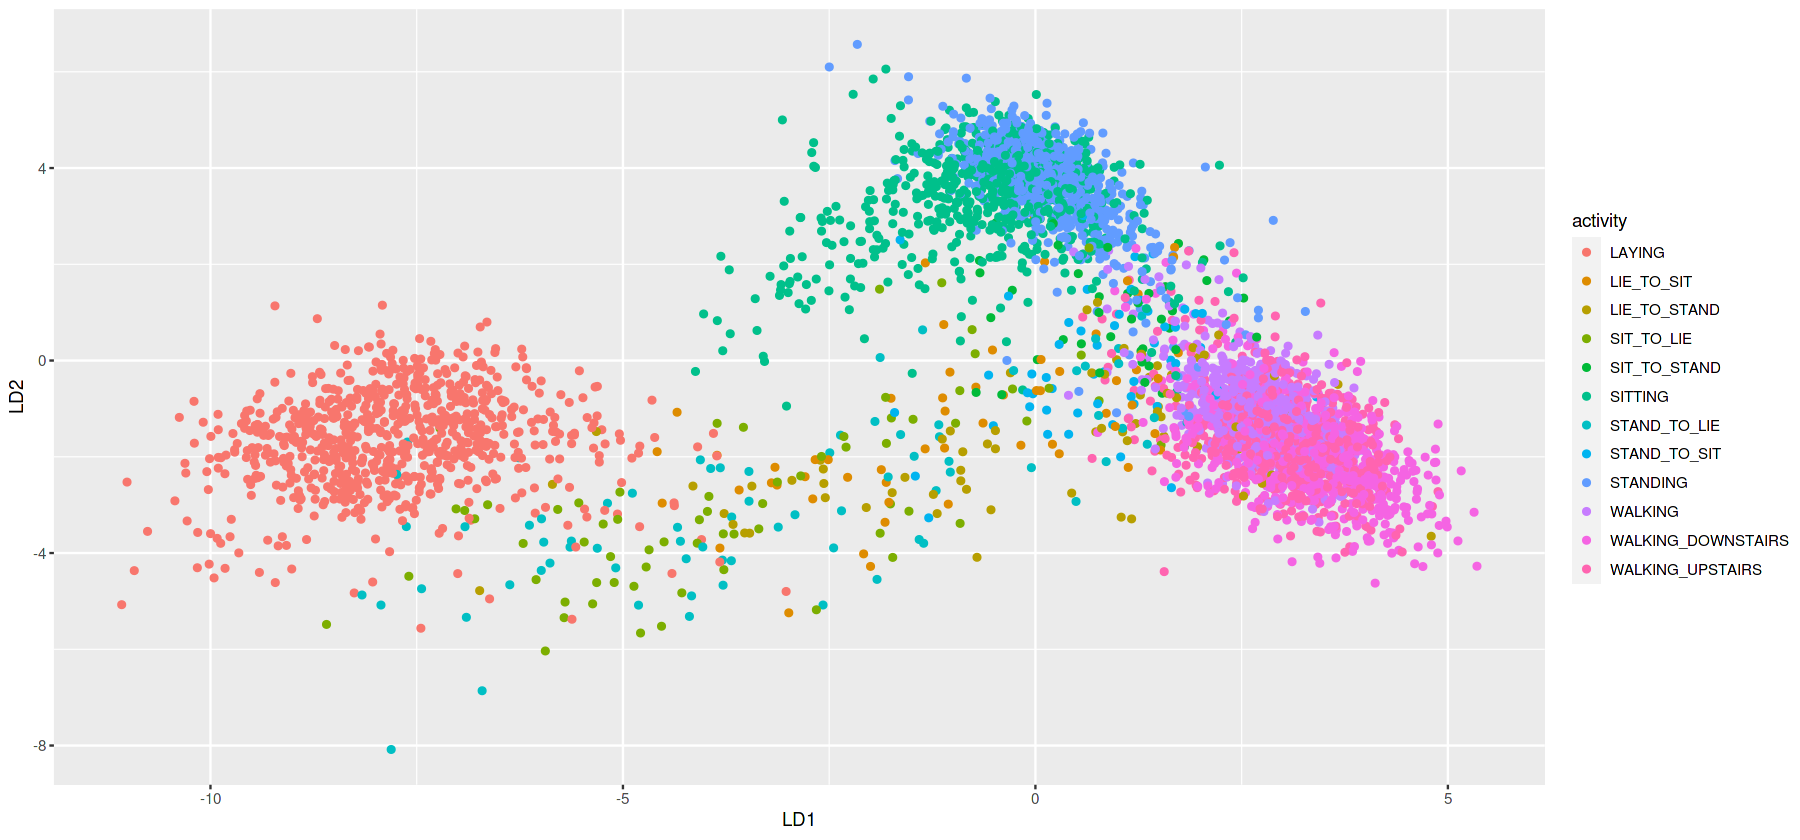

In [180]:
#define data to plot
lda_plot <- cbind(fit_df, predict(lda)$x)

#create plot
ggplot(lda_plot, aes(LD1, LD2)) +
  geom_point(aes(color = activity))

In [194]:
fit_lda = caret::train(activity ~ ., data = selected_fit_df, method="lda", trControl = trcntr)
fit_lda

Linear Discriminant Analysis 

4900 samples
  94 predictor
  12 classes: 'LAYING', 'LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'SITTING', 'STAND_TO_LIE', 'STAND_TO_SIT', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 3922, 3920, 3919, 3920, 3919 
Resampling results:

  Accuracy   Kappa    
  0.8638753  0.8408441


In [200]:
# recursive feature elimination 
ldaProfile <- rfe(fit_df[-1], fit_df$activity,
                  sizes = c(1:122),
                  rfeControl = rfeControl(functions = ldaFuncs, method = "cv", ))

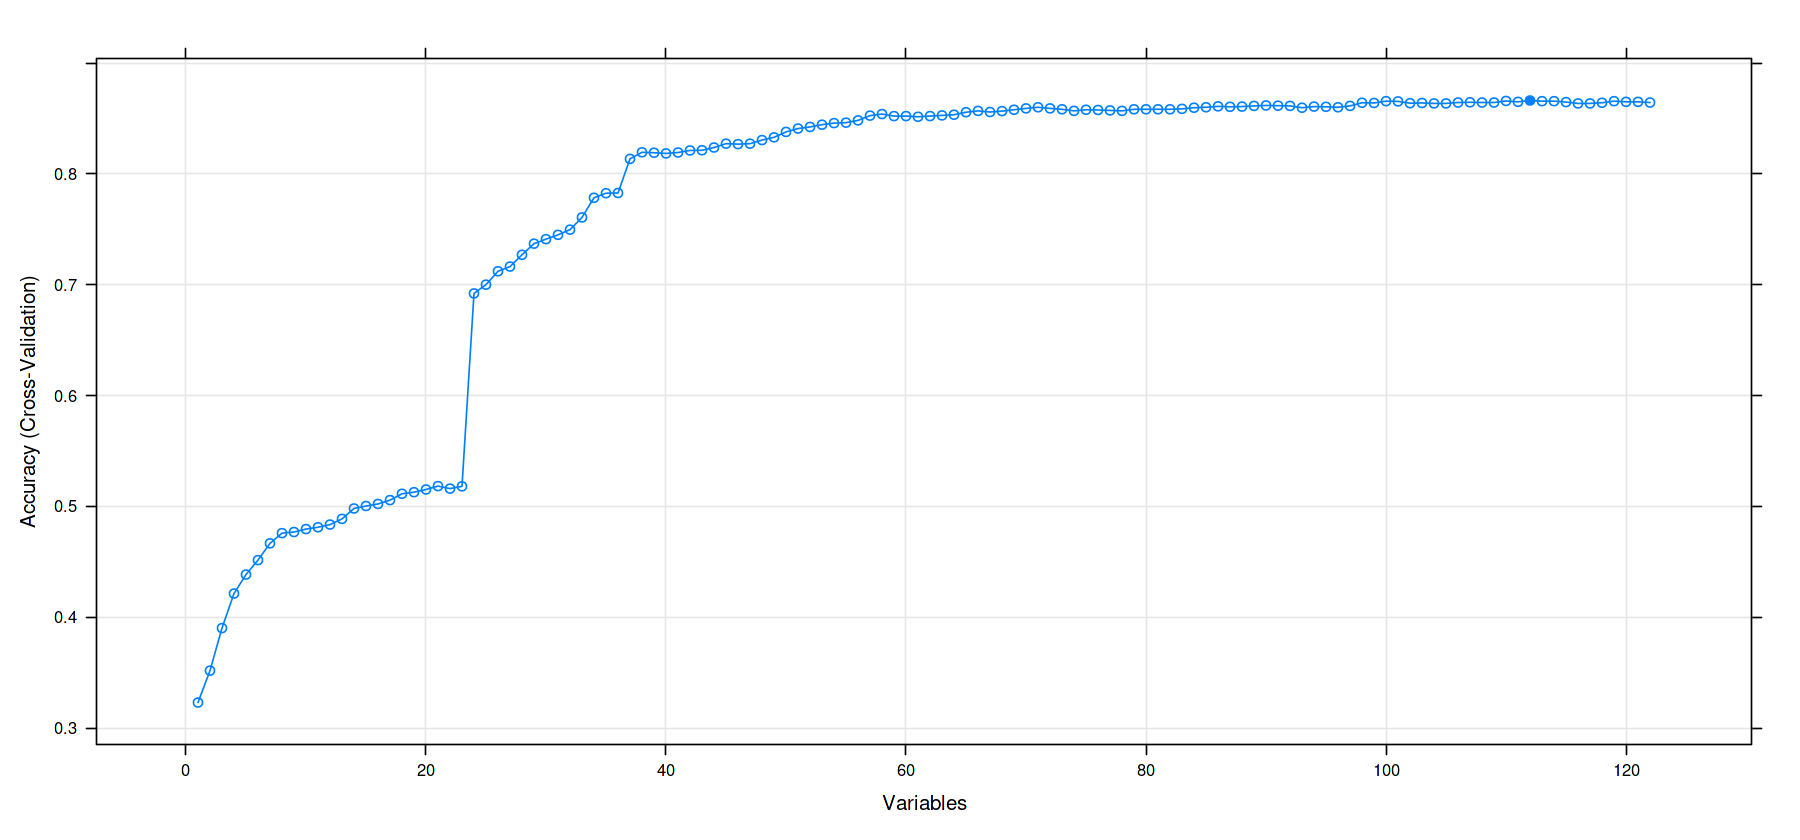

In [201]:
plot(ldaProfile, type = c("g", "o"))

In [97]:
ldaProfile


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD  KappaSD Selected
         1   0.3225 0.1936   0.014987 0.017925         
         2   0.3504 0.2282   0.013656 0.016352         
         3   0.3910 0.2781   0.018926 0.021619         
         4   0.4222 0.3163   0.014826 0.017358         
         5   0.4373 0.3350   0.021169 0.025358         
         6   0.4525 0.3537   0.029629 0.034289         
         7   0.4600 0.3631   0.021427 0.024651         
         8   0.4700 0.3755   0.021266 0.025528         
         9   0.4753 0.3818   0.020947 0.025124         
        10   0.4761 0.3828   0.019874 0.023779         
        11   0.4778 0.3847   0.019008 0.022839         
        12   0.4831 0.3912   0.017173 0.020655         
        13   0.4880 0.3975   0.020848 0.025347         
        14   0.4933 0.4042   0.021727 0.026442         
        15   0.5000 0.4129   0.0167

We can see from the above plot that when the number of variables hit 40, the cv accuracy roughly plateaus. So the following step would be selecting between 30-60 predictor model. 

In [110]:
predictors(ldaProfile)

[1] "X3_band_power_1_acc"      "X2_band_power_1_acc"     
  [3] "mm_diff3_gyro"            "X1_band_power_2_acc"     
  [5] "X1_band_power_4_acc"      "X1_band_entro_3_acc"     
  [7] "X1_band_entro_1_acc"      "X2_band_power_7_acc"     
  [9] "X2_band_entro_5_acc"      "X2_band_power_4_acc"     
 [11] "X1_band_power_5_acc"      "X1_band_power_7_acc"     
 [13] "X1_band_power_6_acc"      "linear_trend1_acc"       
 [15] "X2_band_entro_6_acc"      "X3_band_power_5_acc"     
 [17] "X3_band_power_3_gyro"     "X3_band_power_4_acc"     
 [19] "X2_band_power_5_gyro"     "X3_band_entro_1_acc"     
 [21] "X1_band_power_3_gyro"     "X3_band_power_6_acc"     
 [23] "X3_band_power_7_acc"      "q1_25_acc"               
 [25] "count2_acc"               "q3_50_gyro"              
 [27] "AR1_1_gyro"               "count3_acc"              
 [29] "AR1_2_acc"                "X1_band_power_8_acc"     
 [31] "AR1_2_gyro"               "X2_band_power_8_gyro"    
 [33] "linear_trend2_acc"        "AR12_1_acc"              
 [35] "X2_band_entro_8_acc"      "count1_acc"              
 [37] "q2_75_acc"                "q3_75_acc"               
 [39] "norm_3_acc"               "linear_trend3_acc"       
 [41] "X3_band_power_8_gyro"     "X3_band_entro_8_acc"     
 [43] "norm_2_acc"               "norm_1_acc"              
 [45] "kurt3_gyro"               "X2_band_peak_freq_1_acc" 
 [47] "norm_3_gyro"              "kurt3_acc"               
 [49] "AR12_1_gyro"              "X3_band_peak_freq_1_gyro"
 [51] "f_gyro"                   "X1_band_entro_1_gyro"    
 [53] "kurt2_acc"                "X3_band_peak_freq_1_acc" 
 [55] "q2_50_gyro"               "skew1_acc"               
 [57] "mode1_gyro"               "mode3_gyro"              
 [59] "norm_1_gyro"              "X1_band_peak_freq_1_acc" 
 [61] "X2_band_entro_1_gyro"     "kurt2_gyro"              
 [63] "skew1_gyro"               "mode_perc1_gyro"         
 [65] "f_acc"                    "kurt1_gyro"              
 [67] "X2_band_peak_freq_4_acc"  "X3_band_peak_freq_4_gyro"
 [69] "kurt1_acc"                "mode_perc1_acc"          
 [71] "X3_band_peak_freq_4_acc"  "mode2_gyro"              
 [73] "skew2_acc"                "mode_perc2_acc"          
 [75] "X2_band_peak_freq_2_gyro" "mode_perc3_gyro"         
 [77] "count1_gyro"              "X2_band_peak_freq_3_gyro"
 [79] "X1_band_peak_freq_1_gyro" "count2_gyro"             
 [81] "X1_band_peak_freq_3_acc"  "X3_band_peak_freq_3_gyro"
 [83] "mode_perc2_gyro"          "X3_band_peak_freq_5_gyro"
 [85] "X1_band_peak_freq_4_gyro" "skew2_gyro"              
 [87] "X2_band_peak_freq_3_acc"  "X3_band_peak_freq_2_acc" 
 [89] "linear_trend3_gyro"       "X2_band_peak_freq_1_gyro"
 [91] "X3_band_peak_freq_6_acc"  "count3_gyro"             
 [93] "skew3_gyro"               "X1_band_peak_freq_3_gyro"
 [95] "norm_2_gyro"              "X2_band_peak_freq_6_gyro"
 [97] "X2_band_peak_freq_4_gyro" "X1_band_peak_freq_2_gyro"
 [99] "X1_band_peak_freq_5_gyro" "X3_band_peak_freq_5_acc" 
[101] "X3_band_peak_freq_3_acc"  "X1_band_peak_freq_6_gyro"
[103] "mode_perc3_acc"           "X1_band_peak_freq_2_acc" 
[105] "X1_band_peak_freq_5_acc"  "X3_band_peak_freq_6_gyro"
[107] "skew3_acc"                "X2_band_peak_freq_5_acc" 
[109] "X3_band_peak_freq_2_gyro" "X2_band_peak_freq_2_acc" 
[111] "X2_band_peak_freq_6_acc"  "linear_trend2_gyro"      
[113] "X2_band_peak_freq_5_gyro" "X1_band_peak_freq_7_gyro"
[115] "X2_band_peak_freq_7_gyro"

In [101]:
selected_predictors = predictors(ldaProfile)
selected_fit_df = fit_df %>% select(activity, all_of(selected_predictors))


fit_lda = caret::train(activity ~ ., data = selected_fit_df, method="lda", trControl = trcntr)
fit_lda

Linear Discriminant Analysis 

4900 samples
 115 predictor
  12 classes: 'LAYING', 'LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'SITTING', 'STAND_TO_LIE', 'STAND_TO_SIT', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 3921, 3920, 3920, 3919, 3920 
Resampling results:

  Accuracy   Kappa    
  0.8632646  0.8401318


# 5.3 QDA

While fitting QDA we got an error: 'some group is too small for 'qda''

In [47]:
#fit_qda = caret::train(activity ~ ., data = fit_df, method="qda", trControl = trcntr)
#fit_qda

# 5.3 Naive Bayes

In [48]:
set.seed(1)
options(warn=-1) # We suppress warnings - the naive bayes seems to work but produced some warnings.

fit_nb <- caret::train(activity ~ ., data = selected_fit_df, method = 'nb',trControl = trcntr)
fit_nb
options(warn=0) # Turning warnings back on

ERROR: Error in eval(expr, p): object 'selected_fit_df' not found


# 5.4 KNNs

In [ ]:
fit_knns = caret::train(activity ~ ., data=selected_fit_df, method="knn", trControl = trcntr, preProcess = "scale")
fit_knns

Plotting different number of neighbours and their accuracy.

In [ ]:
plot(fit_knns)

# 5.5 Model Comparison

In [ ]:
models = list(lda = fit_lda, knns=fit_knns, bayes = fit_nb)

# Extract the cross-validated accuracies from each model
Acc = sapply(models, function(mdl) max(mdl$results$Accuracy, na.rm = TRUE)) 

# make a barplot with only the best performing model in red
color = 1 + (Acc >= max(Acc)) 
barplot(Acc, horiz=T, las=1, col = color)

In [ ]:
## Test significance of classifier accuracy differences

# For each model in models compute a predicted label 
preds = sapply(models, predict)  # for each model, a columns of prediction 

# For each prediction, test if the prediction is correct
correct = (preds == clean_df$activity) # matrix of TRUE and FALSE

# For pairwise.table() we need to define a function that returns the p-values
compare_func = function(i,j) mcnemar.test(correct[,i], correct[,j])$p.value

# Compute the table of pairwise comparisons
print(zapsmall(pairwise.table(compare_func, level.names = colnames(preds), "none")),digits=5)

From both the graph and the test of significance table it can be concluded that LDA performs the best.

# 6. Submissions


The test data can be imported in the same way as the training data, you only have to change `Train` to `Test` in the directory path:

In [102]:
filenames_test_acc = list.files("./RawData/Test/", "^acc", full.names = TRUE)
filenames_test_gyr = list.files("./RawData/Test/", "^gyr", full.names = TRUE)

myData_acc_test = map_dfr(filenames_test_acc, extractTimeDomainFeatures, sample_labels) 
myData_gyr_test = map_dfr(filenames_test_gyr, extractTimeDomainFeatures, sample_labels) 
#head(myData_acc_test)

In [103]:
names(myData_acc_test)[-c(1:5,length(myData_acc_test))] <- paste(colnames(myData_acc_test)[-c(1:5,length(myData_acc_test))], "_acc", sep="")
names(myData_gyr_test)[-c(1:5,length(myData_gyr_test))] <- paste(colnames(myData_gyr_test)[-c(1:5,length(myData_gyr_test))], "_gyro", sep="")
#head(myData_acc_test)

In [112]:
myData_test <- myData_acc_test %>% 
    left_join(myData_gyr_test, by = c("epoch", "user_id", "exp_id", "activity", "sampleid", "n_samples" )) %>%
    relocate(n_samples, .after = last_col())

head(myData_test)

epoch,user_id,exp_id,activity,sampleid,m1_acc,m2_acc,m3_acc,sd1_acc,sd2_acc,⋯,X3_band_entro_2_gyro,X3_band_entro_3_gyro,X3_band_entro_4_gyro,X3_band_entro_5_gyro,X3_band_entro_6_gyro,X3_band_entro_7_gyro,X3_band_entro_8_gyro,X3_mean_freq_gyro,X3_sd_freq_gyro,n_samples
<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,2,3,-,0,0.1693034,-0.2382921,0.8003690,0.342781849,0.289369831,⋯,0.79916087,1.881640306,1.669121404,0.511032195,0.287891231,0.237425672,0.02901911587,0.012993141566,0.0014825254791,128
1,2,3,-,128,0.8997071,-0.3948568,-0.2429905,0.199240911,0.229116223,⋯,-2.26005180,2.173837217,2.176215863,1.248192167,1.226401775,1.898588097,0.00008562053,0.029853259433,0.0035356667154,128
2,2,3,-,256,0.9974935,-0.2712565,0.1135525,0.042227583,0.019780220,⋯,0.65697155,0.250111415,0.140153417,0.105958902,0.100782152,0.018686489,0.00086485923,0.000449797384,0.0000864828955,128
3,2,3,-,384,0.9928928,-0.2702691,0.1391276,0.004056281,0.007968916,⋯,0.05190038,0.005825745,0.004139482,0.002102619,0.001896939,0.001406067,0.00006458291,0.000011576733,0.0000017734683,128
4,2,3,-,512,0.9908854,-0.2861979,0.1286350,0.003650795,0.008527467,⋯,0.01436001,0.003181805,0.002682749,0.001212080,0.001303262,0.001204529,0.00005844397,0.000006702299,0.0000008947963,128
5,2,3,-,640,0.9909180,-0.2904948,0.1215712,0.003467951,0.006150943,⋯,0.02508733,0.003852241,0.003120362,0.001192877,0.001676317,0.003024710,0.00014942609,0.000012449897,0.0000016810486,128


reducing the number of predictions as before

In [113]:
myData_test <- myData_test[,colnames(clean_df)] 

epoch,user_id,exp_id,activity,sampleid,q1_25_acc,q2_75_acc,q3_75_acc,skew1_acc,skew2_acc,⋯,X3_band_peak_freq_1_gyro,X3_band_peak_freq_2_gyro,X3_band_peak_freq_3_gyro,X3_band_peak_freq_4_gyro,X3_band_peak_freq_5_gyro,X3_band_peak_freq_6_gyro,X3_band_peak_freq_7_gyro,X3_band_power_3_gyro,X3_band_power_8_gyro,n_samples
<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,2,3,-,0,-0.09618056,-0.04131945,0.93993061,-0.666199319,-0.965484862,⋯,0.0078125,0.0781250,0.1875000,0.2343750,0.3203125,0.3984375,0.4687500,0.33069678706,0.00559598103947,128
1,2,3,-,128,0.84687508,-0.24305557,-0.13055556,-0.953896587,-1.281720946,⋯,0.0156250,0.0781250,0.1562500,0.2187500,0.3203125,0.4218750,0.4296875,0.36707249877,0.00000723341933,128
2,2,3,-,256,0.98333341,-0.25972222,0.13888890,-0.650549512,-0.852260120,⋯,0.0312500,0.0937500,0.2109375,0.2812500,0.2890625,0.3906250,0.4531250,0.00578821385,0.00009318697448,128
3,2,3,-,384,0.98888888,-0.26527779,0.15000001,0.086583163,-0.665091528,⋯,0.0078125,0.1015625,0.1796875,0.2578125,0.3515625,0.3984375,0.4531250,0.00007050869,0.00000531790290,128
4,2,3,-,512,0.98888888,-0.28159723,0.13472223,0.223512451,-0.140496847,⋯,0.0390625,0.0781250,0.1796875,0.2578125,0.3515625,0.3750000,0.4453125,0.00003579313,0.00000476967808,128
5,2,3,-,640,0.98888888,-0.28611112,0.12638889,0.042951069,-0.116378649,⋯,0.0468750,0.1093750,0.1562500,0.2421875,0.3281250,0.4218750,0.4609375,0.00004592495,0.00001330949066,128
6,2,3,-,768,0.98749999,-0.29583334,0.12222223,-0.117280498,0.030465637,⋯,0.0156250,0.0859375,0.1796875,0.2265625,0.2968750,0.3671875,0.4843750,0.00003505100,0.00000246608015,128
7,2,3,-,896,0.98749999,-0.29166669,0.12500000,-0.160083856,-0.133027275,⋯,0.0312500,0.1328125,0.1796875,0.2500000,0.2968750,0.4062500,0.4375000,0.00003963549,0.00000008975754,128
8,2,3,-,1024,0.98749999,-0.29583334,0.12777779,-0.378095951,0.006602904,⋯,0.0234375,0.1093750,0.1796875,0.2421875,0.3437500,0.3906250,0.4843750,0.00003189639,0.00002143636573,128


## NAs in the test data
there is two rows that have NAs from the feature extraction.
they belong to the files of user 4, experiment 7 and user 9, experiment 18.
We could not figure out why this happened, so for now we replaced the NAs with 0 for now.

In [114]:
nas <- which(is.na(myData_test), arr.ind = TRUE)
rows<- nas[, 1]
cols <- nas[, 2]
unique(rows)
unique(cols)
myData_test[unique(rows),unique(cols)] <- 0
#myData_test[unique(rows),-c(1:5,unique(cols), 101)] 

integer(0)

integer(0)

In [195]:
predictions <- predict(fit_lda, newdata = myData_test)
nrow(myData_test)
length(predictions)
myData_test$activity <- predictions

[1] 2550

[1] 2550

## Formatting the submission file

To help you turning your predictions into the right format, the following code can help. Here it is executed on the training set data frame, but the same can be applied to the test set data frame.

In [196]:
head(myData_test)

epoch,user_id,exp_id,activity,sampleid,q1_25_acc,q2_75_acc,q3_75_acc,skew1_acc,skew2_acc,⋯,X3_band_peak_freq_1_gyro,X3_band_peak_freq_2_gyro,X3_band_peak_freq_3_gyro,X3_band_peak_freq_4_gyro,X3_band_peak_freq_5_gyro,X3_band_peak_freq_6_gyro,X3_band_peak_freq_7_gyro,X3_band_power_3_gyro,X3_band_power_8_gyro,n_samples
<dbl>,<dbl>,<dbl>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,2,3,LIE_TO_STAND,0,-0.09618056,-0.04131945,0.9399306,-0.66619932,-0.9654849,⋯,0.0078125,0.0781250,0.1875000,0.2343750,0.3203125,0.3984375,0.4687500,0.33069678706,0.005595981039,128
1,2,3,STAND_TO_SIT,128,0.84687508,-0.24305557,-0.1305556,-0.95389659,-1.2817209,⋯,0.0156250,0.0781250,0.1562500,0.2187500,0.3203125,0.4218750,0.4296875,0.36707249877,0.000007233419,128
2,2,3,SITTING,256,0.98333341,-0.25972222,0.1388889,-0.65054951,-0.8522601,⋯,0.0312500,0.0937500,0.2109375,0.2812500,0.2890625,0.3906250,0.4531250,0.00578821385,0.000093186974,128
3,2,3,STANDING,384,0.98888888,-0.26527779,0.1500000,0.08658316,-0.6650915,⋯,0.0078125,0.1015625,0.1796875,0.2578125,0.3515625,0.3984375,0.4531250,0.00007050869,0.000005317903,128
4,2,3,STANDING,512,0.98888888,-0.28159723,0.1347222,0.22351245,-0.1404968,⋯,0.0390625,0.0781250,0.1796875,0.2578125,0.3515625,0.3750000,0.4453125,0.00003579313,0.000004769678,128
5,2,3,STANDING,640,0.98888888,-0.28611112,0.1263889,0.04295107,-0.1163786,⋯,0.0468750,0.1093750,0.1562500,0.2421875,0.3281250,0.4218750,0.4609375,0.00004592495,0.000013309491,128


In [197]:
myData_test %>%

    # prepend "user" and "exp" to user_id and exp_id
    mutate(
        user_id = paste(ifelse(user_id < 10, "user0", "user"), user_id, sep=""), 
        exp_id = paste(ifelse(exp_id < 10, "exp0", "exp"), exp_id, sep="")
    ) %>% 

    # unit columnes user_id, exp_id and sample_id into a string 
    # separated by "_" and store it in the new variable `Id`
    unite(Id, user_id, exp_id, sampleid) %>%

    # retain only the `Id` and  predictions
    dplyr::select(Id, Predicted = activity) %>%

    # write to file
    write_csv("submission.csv")


# Check the result: print first 20 lines in the submission file
cat(readLines("submission.csv",20), sep="\n")

Id,Predicted
user02_exp03_0,LIE_TO_STAND
user02_exp03_128,STAND_TO_SIT
user02_exp03_256,SITTING
user02_exp03_384,STANDING
user02_exp03_512,STANDING
user02_exp03_640,STANDING
user02_exp03_768,SITTING
user02_exp03_896,STANDING
user02_exp03_1024,STANDING
user02_exp03_1152,STANDING
user02_exp03_1280,STANDING
user02_exp03_1408,STAND_TO_SIT
user02_exp03_1536,SIT_TO_STAND
user02_exp03_1664,STANDING
user02_exp03_1792,SITTING
user02_exp03_1920,SITTING
user02_exp03_2048,SITTING
user02_exp03_2176,SITTING
user02_exp03_2304,SITTING


# 7. Division of Work

This is group 07 of competition 2, group members: Gustaw Opielka, Lucy Zhang, Sinja Chen.
The distribution of work in this group was as follows: Every group member contributed to coming up with features to use for the models. Histogram-based features were coded by Sinja, Frequency domain features by Lucy and Time domain, distribution based and linear trend features by Gustaw. With fitting the models, logistic regression and LDA was written by Lucy and QDA by Sinja, even though currently there are some problems with fitting the model. Data pre-processing, KNN, naive Bayes, and model comparisons were written by Gustaw.